In [ ]:
import argparse
import os
import shutil

import numpy as np
import polars as pl
import yaml
from joblib import delayed
from joblib import Parallel
from tifffile import imwrite
from towbintools.foundation.image_handling import read_tiff_file
from towbintools.data_analysis.time_series import smooth_series_classified, correct_series_with_classification
from towbintools.foundation.image_quality import TENG_VARIANCE
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

np.random.seed(387799)

def process_strains(strains):
    # to be correct the strain number needs to be followed by a separator like -, _ or space
    correct_strains = []
    if strains is None:
        return correct_strains
    for strain in strains:
        correct_strains.append(strain + "-")
        correct_strains.append(strain + "_")
        correct_strains.append(strain + " ")
    return correct_strains


def get_analysis_filemap(experiment_path, get_annotated_only=False):
    directories = [
        os.path.join(experiment_path, d)
        for d in os.listdir(experiment_path)
        if os.path.isdir(os.path.join(experiment_path, d))
    ]

    analysis_directories = [d for d in directories if "analysis" in d]
    report_directories = [os.path.join(d, "report") for d in analysis_directories]

    report_directories = [d for d in report_directories if os.path.isdir(d)]

    filemap_files = []
    for report_dir in report_directories:
        files = [os.path.join(report_dir, f) for f in os.listdir(report_dir)]
        if get_annotated_only:
            files = [f for f in files if "analysis_filemap_annotated" in f]
        else:
            files = [f for f in files if "analysis_filemap" in f]
        if files:
            filemap_files.sort(key=lambda x: os.path.getctime(x))
            filemap_files.append(os.path.join(report_dir, files[-1]))

    if filemap_files:
        filemap_files.sort(key=lambda x: os.path.getctime(x))
        return os.path.join(report_dir, filemap_files[-1])

    return None


def find_all_relevant_filemaps(
    experiment_directories,
    experiments_to_always_include,
    keywords_to_include,
    experiments_to_exclude,
    valid_scopes_expanded,
    keywords_to_exclude,
    database_config,
    get_annotated_only=False,
):
    filemaps = []
    strains = process_strains(database_config.get("strains", []))
    magnifications = database_config.get("magnifications", [])
    processed_magnifications = []
    for mag in magnifications:
        processed_magnifications.append(mag)
        processed_magnifications.append(mag.lower())
        processed_magnifications.append(mag.upper())

    magnifications = list(set(processed_magnifications))

    for exp in experiment_directories:
        experiment_name = os.path.basename(os.path.normpath(exp))

        # check if the experiment is in the list of experiments to always include
        if experiment_name in experiments_to_always_include:
            filemap = get_analysis_filemap(exp, get_annotated_only=get_annotated_only)
            if filemap:
                filemaps.append(filemap)
                continue

        if any(keyword in experiment_name for keyword in keywords_to_include):
            filemap = get_analysis_filemap(exp, get_annotated_only=get_annotated_only)
            if filemap:
                filemaps.append(filemap)
                continue

        # check if the experiment is in the list of experiments to exclude
        if experiment_name in experiments_to_exclude:
            continue

        if not any(mag in experiment_name for mag in magnifications) and magnifications:
            continue

        if not any(scope in experiment_name for scope in valid_scopes_expanded):
            continue

        if any(keyword in experiment_name for keyword in keywords_to_exclude):
            continue

        if not any(strain in experiment_name for strain in strains) and strains:
            continue

        filemap = get_analysis_filemap(exp, get_annotated_only=get_annotated_only)

        if filemap:
            filemaps.append(filemap)

    return filemaps


def pick_within_larval_stage(filemap, ls_beg, ls_end, n_picks=1):
    try:
        if np.isnan(ls_beg) or np.isnan(ls_end):
            return []

        filemap_of_stage = filemap.filter(
            (pl.col("Time") >= ls_beg) & (pl.col("Time") <= ls_end)
        )

        if filemap_of_stage.height > 0:
            picks = min(n_picks, filemap_of_stage.height)
            picked_filemap = filemap_of_stage.sample(picks, with_replacement=False)
            picked_images = picked_filemap.select(pl.col("raw")).to_series().to_list()

            return picked_images
        else:
            return []
    except Exception as e:
        print(
            f"Error in picking image within larval stage: {ls_beg}, {ls_end}. Error: {e}"
        )
        return []


def get_images_from_filemap(
    filemap_path,
    database_config,
    valid_scopes_expanded,
    channel,
    threshold=0.95,
    lmbda=0.0075,
    extra_adulthood_time=40,
    n_picks=10,
):
    global variation_to_unified_scope_name
    experiment_name = filemap_path.split("/")[-4]
    filemap_df = pl.read_csv(
        filemap_path,
        infer_schema_length=10000,
        null_values=["np.nan", "[nan]", "", "NaN", "nan", "NA", "N/A"],
    )

    # if Ignore is in the columns, remove all rows where Ignore is True
    if "Ignore" in filemap_df.columns:
        filemap_df = filemap_df.filter(~pl.col("Ignore"))

    # first check if the filemap has the required columns
    worm_type_columns = [column for column in filemap_df.columns if "worm_type" in column]
    channel_name = f'ch{channel[0] + 1}'
    if "ExperimentTime" not in filemap_df.columns or filemap_df["ExperimentTime"].is_null().all(): 
        # assume that ExperimentTime is in seconds and is equal to Time / 6 (10 min intervals)
        # cast time to float
        filemap_df = filemap_df.with_columns(
            pl.col("Time").cast(pl.Float64)
        )
        filemap_df = filemap_df.with_columns(
            (pl.col("Time")/6).alias("ExperimentTime").cast(pl.Float64)
        )
    else:
        # cast ExperimentTime to float
        filemap_df = filemap_df.with_columns(
            pl.col("ExperimentTime").cast(pl.Float64)
        )
        filemap_df = filemap_df.with_columns(
            (pl.col("ExperimentTime")/3600).alias("ExperimentTime")
        )

    database = pl.DataFrame()
        
    seg_columns = [column for column in filemap_df.columns if ((f'{channel_name}_seg' in column) and ("str" not in column))]
    straigthened_raw = f'{channel_name}_raw_str'
    straigthened_raw_columns = [column for column in filemap_df.columns if (straigthened_raw in column)]
    if len(straigthened_raw_columns) == 0:
        print(
            f"Skipping experiment {experiment_name} as it does not have straightened raw images for channel {channel_name}."
        )
        return database
    # remove the previous raw column if it exists
    if "raw" in filemap_df.columns:
        filemap_df = filemap_df.drop("raw")
    filemap_df = filemap_df.rename({straigthened_raw_columns[0]:"raw"})
    volume_columns = [column for column in filemap_df.columns if ((channel_name in column) and ("volume" in column))]
    # if len(worm_type_columns) == 0 or len(seg_columns) == 0 or len(volume_columns) == 0:
    if len(worm_type_columns) == 0 or len(volume_columns) == 0:
        print(
            f"Skipping experiment {experiment_name} as it does not have worm type or segmentation columns."
        )
        return database
    seg_column = seg_columns[0]
    worm_type_column = worm_type_columns[0]

    rows = []

    filemaps_of_points = filemap_df.partition_by("Point")
    stage_proportions = database_config.get("stage_proportions", None)

    microscope = [scope for scope in valid_scopes_expanded if scope in experiment_name][
        0
    ]
    microscope = variation_to_unified_scope_name.get(microscope, microscope)


    print(f"Microscope found: {microscope} in experiment {experiment_name}")


    for filemap in filemaps_of_points:
        # randomly ignore the point 50% of the time to reduce dataset size
        if np.random.rand() < 0.98:
            continue
        if "M4" in filemap.columns:
            # if M4 is annotated, remove rows where Time > M4 + extra_adulthood_time
            m4 = filemap.select(pl.col("M4")).row(0)[0]
            if m4 is not None and not np.isnan(m4):
                filemap = filemap.filter(
                    pl.col("Time") <= m4 + extra_adulthood_time
                )

        # remove rows with time too close to the molts
        # we need to do this because the series is not smooth around the molts
        molts = ["M1", "M2", "M3", "M4"]
        for molt in molts:
            if molt in filemap.columns:
                molt_time = filemap.select(pl.col(molt)).row(0)[0]
                if molt_time is not None and not np.isnan(molt_time):
                    filemap = filemap.filter(
                        (pl.col("Time") < molt_time - 4)
                        | (pl.col("Time") > molt_time + 4)
                    )

        point = filemap.select(pl.col("Point")).row(0)[0]
        volume = filemap.select(pl.col(volume_columns[0])).to_numpy().squeeze()
        # skip point if less than 10 data points
        if np.sum(~np.isnan(volume)) < 10:
            continue
        worm_types = filemap.select(pl.col(worm_type_column)).to_numpy().squeeze()
        corrected_volume = correct_series_with_classification(volume, worm_types)

        experiment_time = filemap.select(pl.col("ExperimentTime")).to_numpy().squeeze()

        smoothed_volume = smooth_series_classified(
            volume,
            experiment_time,
            worm_types=worm_types,
            lmbda=lmbda,
        )

        normalized_residuals = (corrected_volume - smoothed_volume)/smoothed_volume

        confirmed_errors = np.where(worm_types == 'error')[0]
        threshold_value = np.quantile(np.abs(normalized_residuals), threshold)
        potential_errors = np.where(np.abs(normalized_residuals) > threshold_value)[0]
        potential_good = np.where(np.abs(normalized_residuals) <= threshold_value)[0]
        # remove confirmed errors from potential errors
        potential_errors = np.setdiff1d(potential_errors, confirmed_errors)
        # remove confirmed errors from potential good
        potential_good = np.setdiff1d(potential_good, confirmed_errors)
    
        # drop 95% of potential good to reduce dataset size
        if len(potential_good) > 0:
            potential_good = np.random.choice(
                potential_good, size=int(len(potential_good) * 0.05), replace=False
            )
        eggs = np.where(worm_types == 'egg')[0]
        

            # Vectorized creation of all rows
        indices = np.concatenate([potential_errors, potential_good, eggs, confirmed_errors])
        classes = np.concatenate([
            np.full(len(potential_errors), "potential_error"),
            np.full(len(potential_good), "good"),
            np.full(len(eggs), "egg"),
            np.full(len(confirmed_errors), "error")
        ])
        
        images = filemap.select(pl.col("raw")).to_numpy().squeeze()[indices]
        # replace external.data/TowbinLab by towbin.data/shared
        images = [img.replace("TowbinLab", "shared") for img in images]
        images = [img.replace("external.data", "towbin.data") for img in images]
        
        masks = filemap.select(pl.col(seg_column)).to_numpy().squeeze()[indices]
        masks = [m.replace("TowbinLab", "shared") for m in masks]
        masks = [m.replace("external.data", "towbin.data") for m in masks]

        # only keep if both image and mask exist
        valid_indices = [i for i, (img, msk) in enumerate(zip(images, masks)) if os.path.exists(img) and os.path.exists(msk)]
        classes = [classes[i] for i in valid_indices]
        images = [images[i] for i in valid_indices]
        masks = [masks[i] for i in valid_indices]
        filemap_rows = [
            {
                "Class": clss,
                "Image": img,
                "Microscope": microscope,
                "Point": point,
                "Stage": "unknown",
                "Mask": mask
            }
            for clss, img, mask in zip(classes, images, masks)
            # for clss, img in zip(classes, images)
        ]
        rows.extend(filemap_rows)
    database = pl.DataFrame(
        rows, 
        schema={
            "Class": pl.Utf8,
            "Image": pl.Utf8,
            "Microscope": pl.Utf8,
            "Point": pl.Int64,
            "Stage": pl.Utf8,
            "Mask": pl.Utf8,
        },
    )
    
    return database


def calculate_image_combinations(database_size, scope_proportions, stage_proportions):
    """Calculate number of images needed for each scope and stage combination."""
    combinations = {}

    # Calculate for each scope and stage combination
    for scope, scope_prop in scope_proportions.items():
        combinations[scope] = {}
        if not stage_proportions:
            n_images = int(database_size * scope_prop)
            combinations[scope]["unknown"] = n_images
        else:
            for stage, stage_prop in stage_proportions.items():
                n_images = int(database_size * scope_prop * stage_prop)
                combinations[scope][stage] = n_images

    return combinations

config_path = "qc_dataset_config.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

storage_path = config.get("storage_path", "")
valid_subdirectories = config.get("valid_subdirectories", [])

database_path = config.get("database_path", None)
database_configs = config.get("database_configs", {})
extra_adulthood_time = config.get("extra_adulthood_time", 0)
valid_scopes = config.get("valid_scopes", [])
scopes_alt_names = config.get("scopes_alt_names", {})
keywords_to_exclude = config.get("keywords_to_exclude", [])
keywords_to_include = config.get("keywords_to_include", [])
experiments_to_consider = config.get("experiments_to_consider", [])
experiments_to_always_include = config.get("experiments_to_always_include", [])
experiments_to_exclude = config.get("experiments_to_exclude", [])
n_picks_per_stage = config.get("n_picks_per_stage", 10)
lmbda = config.get("lambda", 0.0075)
threshold = config.get("threshold", 0.95)
valid_scopes_expanded = []
for scope in valid_scopes:
    if scope in scopes_alt_names:
        valid_scopes_expanded.extend(scopes_alt_names[scope])
    else:
        valid_scopes_expanded.append(scope)

os.makedirs(database_path, exist_ok=True)

# Create mapping from variations to standard names
variation_to_unified_scope_name = {}
for microscope, variations in scopes_alt_names.items():
    for variation in variations:
        variation_to_unified_scope_name[variation] = microscope

os.makedirs(database_path, exist_ok=True)
for sub_db in database_configs.keys():
    sub_db_dir = os.path.join(database_path, sub_db)
    os.makedirs(sub_db_dir, exist_ok=True)
    os.makedirs(os.path.join(sub_db_dir, "images"), exist_ok=True)
    # os.makedirs(os.path.join(sub_db_dir, "masks"), exist_ok=True)

# get all experiment directories
experiment_directories = []
valid_subdirectories = [
    os.path.join(storage_path, sub_dir) for sub_dir in valid_subdirectories
]
if experiments_to_consider:
    experiment_directories = experiments_to_consider
else:
    for exp_dir in valid_subdirectories:
        experiment_directories.extend(
            [
                os.path.join(exp_dir, d)
                for d in os.listdir(exp_dir)
                if os.path.isdir(os.path.join(exp_dir, d))
            ]
        )

experiment_directories.extend(experiments_to_always_include)
experiment_directories = list(set(experiment_directories))

# filter experiment directories based on the criteria and get their filemaps
for database_name, database_config in database_configs.items():
    channel = database_config.get("channel", [0])
    get_annotated_only = database_config.get("stage_proportions", None) is not None
    filemaps = find_all_relevant_filemaps(
        experiment_directories,
        experiments_to_always_include,
        keywords_to_include,
        experiments_to_exclude,
        valid_scopes_expanded,
        keywords_to_exclude,
        database_config,
        get_annotated_only=get_annotated_only,
    )

    database = pl.DataFrame(schema={
        "Class": pl.Utf8,
        "Image": pl.Utf8,
        "Microscope": pl.Utf8,
        "Point": pl.Int64,
        "Stage": pl.Utf8,
        "Mask": pl.Utf8,
    })
    for filemap in filemaps:
        try:
            database = database.vstack(
                get_images_from_filemap(
                    filemap,
                    database_config,
                    valid_scopes_expanded,
                    channel=channel,
                    lmbda=lmbda,
                    threshold=threshold,
                    extra_adulthood_time=extra_adulthood_time,
                    n_picks=n_picks_per_stage,
                )
            )
        except Exception as e:
            print(f"Error processing filemap {filemap}: {e}")
            continue

    class_proportions = {"error": 0.25, "potential_error": 0.25, "good": 0.4, "egg": 0.1}
    # calculate number of images per class
    class_counts = {}
    total_images = database_config.get("size", 1000)
    for cls, prop in class_proportions.items():
        class_counts[cls] = int(total_images * prop)
    # sample images per class
    sampled_database = pl.DataFrame(schema={
        "Class": pl.Utf8,
        "Image": pl.Utf8,
        "Microscope": pl.Utf8,
        "Point": pl.Int64,
        "Stage": pl.Utf8,
        "Mask": pl.Utf8,
    })
    for cls, count in class_counts.items():
        class_images = database.filter(pl.col("Class") == cls)
        n = min(count, class_images.height)
        class_images = class_images.sample(n, with_replacement=False)
        sampled_database = sampled_database.vstack(class_images)

    # sort the dataset by class to group similar images together
    sampled_database = sampled_database.sort("Class")
    # create output names
    def get_output_name(i, row):
        return f'image_{i}_{row["Class"]}_{row["Microscope"]}.tiff'
    sampled_database = sampled_database.with_columns(pl.arange(0, sampled_database.height).alias("Index"))
    sampled_database = sampled_database.with_columns(
        pl.struct(["Index", "Class", "Microscope"])
        .map_elements(lambda x: get_output_name(x["Index"], x), return_dtype=pl.String)
        .alias("OutputName")
    )
    sampled_database = sampled_database.select(pl.exclude("Index", "Point"))
    sampled_database.write_csv(
        os.path.join(
            database_path, database_name, f"{database_name}_classification_filemap.csv"
        )
    )

    # copy the config file to the database directory
    shutil.copy(
        config_path,
        os.path.join(database_path, database_name, f"{database_name}_config.yaml"),
    )

    images_output_dir = os.path.join(database_path, database_name, "images")
    masks_output_dir = os.path.join(database_path, database_name, "masks")
    os.makedirs(images_output_dir, exist_ok=True)
    os.makedirs(masks_output_dir, exist_ok=True)
    for row in tqdm(sampled_database.iter_rows(named=True), total=sampled_database.height):
        image_path = row["Image"]
        mask_path = row["Mask"]
        image = read_tiff_file(image_path, channels_to_keep=channel)
        mask = read_tiff_file(mask_path)
        image_name = row["OutputName"]
        # save the image
        imwrite(os.path.join(images_output_dir, image_name), image, compression="zlib")
        imwrite(os.path.join(masks_output_dir, image_name), mask, compression="zlib")


Microscope found: ti2 in experiment 20240122_Orca_10x_rheb-1aid_wBT186-376-377-378_25C_20240122_185017_279
Microscope found: squid in experiment 20240612_squid_wBT446_10X_NaCl
Microscope found: ti2 in experiment 20221028_Ti2_10x_IGhits-RNAi_wBT160-182-186_25C_20221028_170009_651
Error processing filemap /mnt/towbin.data/shared/kstojanovski/20221028_Ti2_10x_IGhits-RNAi_wBT160-182-186_25C_20221028_170009_651/analysis/report/analysis_filemap.csv: vals_x input data needs to be monotonically increasing. Offending index: 202
Microscope found: squid in experiment 20251706_10x_squid_wBT446_NaCl_20°C
Skipping experiment 20220629_Ti2_20x_160-182-190_pumping_25C_20220629_154238_325 as it does not have straightened raw images for channel ch2.
Error processing filemap /mnt/towbin.data/shared/kstojanovski/20220629_Ti2_20x_160-182-190_pumping_25C_20220629_154238_325/analysis/report/analysis_filemap.csv: unable to append to a DataFrame of width 6 with a DataFrame of width 0
Microscope found: ti2 in ex

2000it [03:27,  9.63it/s]


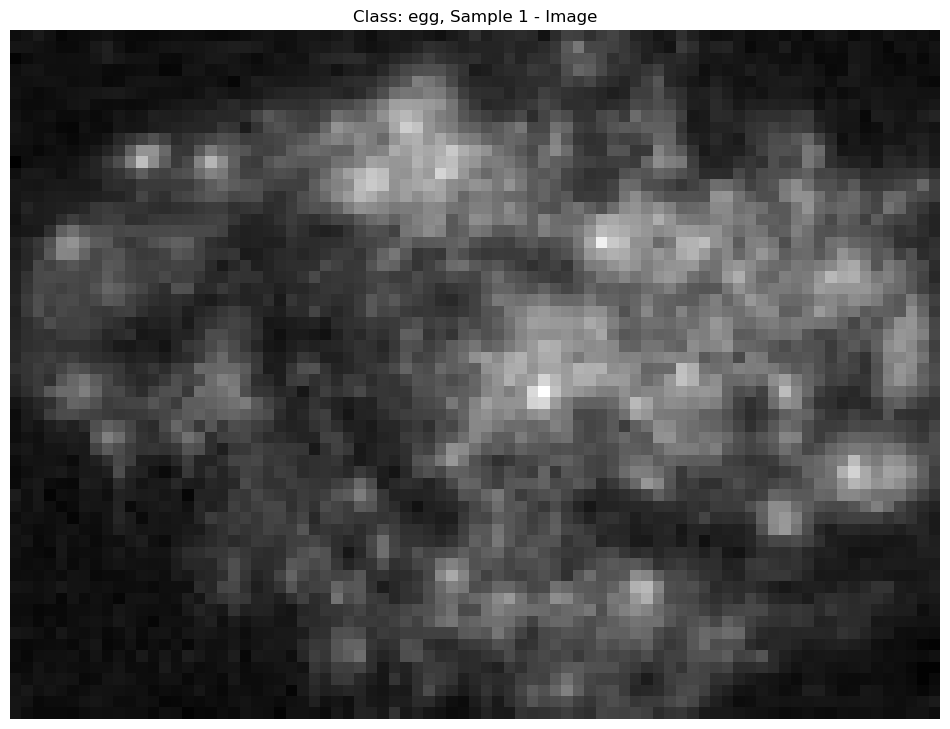

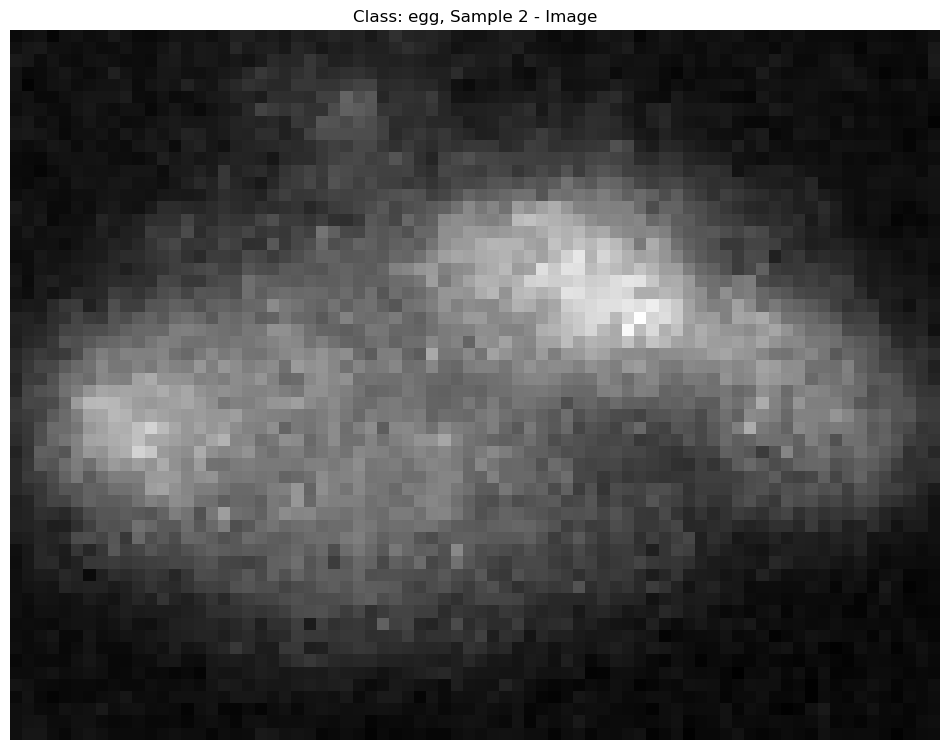

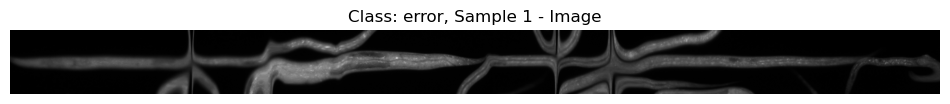

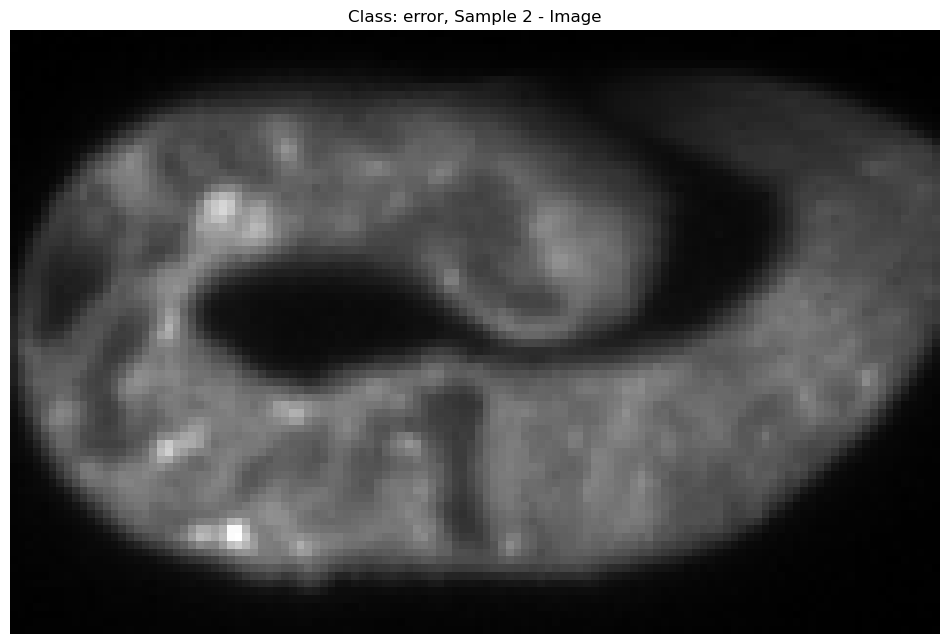

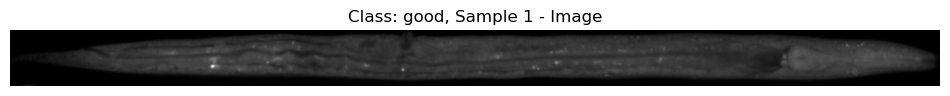

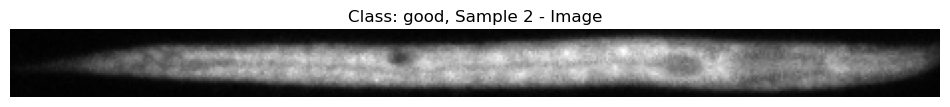

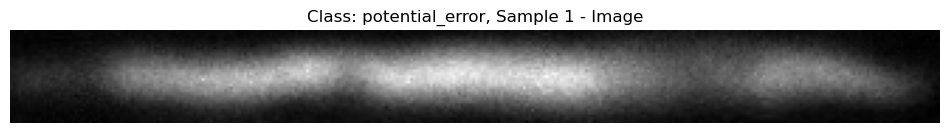

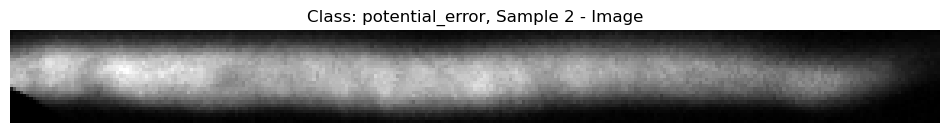

In [ ]:
# plot 2 examples of each class
import matplotlib.pyplot as plt
classes = sorted(database.select(pl.col("Class")).unique().to_series().to_list())
for clss in classes:
    class_images = database.filter(pl.col("Class") == clss)
    n_images = min(2, class_images.height)
    sampled_images = class_images.sample(n_images, with_replacement=False).to_pandas()
    for i, row in enumerate(sampled_images.iterrows()):
        image_path = row[1]["Image"]
        # mask_path = row[1]["Mask"]
        image = read_tiff_file(image_path)
        # mask = read_tiff_file(mask_path)
        channel = channel[0] if isinstance(channel, list) else channel
        if channel >= image.shape[0]:
            channel = image.shape[0] - 1
        # image = image[channel, :, :]  # select the channel
        if len(image.shape) == 3:
            image = image[channel, :, :]  # select the channel
        
        
        # figure, ax = plt.subplots(1, 2, figsize=(12, 12))
        # ax[0].imshow(image, cmap='gray')
        # ax[0].set_title(f'Class: {clss}, Sample {i+1} - Image')
        # ax[0].axis('off')
        # ax[1].imshow(mask, cmap='gray')
        # ax[1].set_title(f'Class: {clss}, Sample {i+1} - Mask')
        # ax[1].axis('off')
        # plt.show()

        fig = plt.figure(figsize=(12,12))
        plt.imshow(image, cmap='gray')
        plt.title(f'Class: {clss}, Sample {i+1} - Image')        
        plt.axis('off')
        plt.show()